<a href="https://colab.research.google.com/github/zaenalSamsul/Covid-19/blob/main/Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

## Path Direktori Dataset
BASE_DIR =  "/content/drive/MyDrive/Covid-19"
TRAIN_DIR = os.path.join(BASE_DIR, 'train/')
VAL_DIR = os.path.join(BASE_DIR, 'VAL/')
TEST_DIR = os.path.join(BASE_DIR, 'test/')
IMG_PATH = 'path_to_your_dataset/'  # Replace with your dataset directory
TRAIN_DIR = 'train/'
TEST_DIR = 'test/'

In [3]:
# Pastikan folder TRAIN, VAL, dan TEST ada
os.makedirs(os.path.join(TRAIN_DIR, 'PNEUMONIA'), exist_ok=True)
os.makedirs(os.path.join(TRAIN_DIR, 'NORMAL'), exist_ok=True)
os.makedirs(os.path.join(VAL_DIR, 'PNEUMONIA'), exist_ok=True)
os.makedirs(os.path.join(VAL_DIR, 'NORMAL'), exist_ok=True)
os.makedirs(os.path.join(TEST_DIR, 'PNEUMONIA'), exist_ok=True)
os.makedirs(os.path.join(TEST_DIR, 'NORMAL'), exist_ok=True)

In [4]:
# Fungsi untuk memindahkan data ke folder TRAIN, VAL, TEST
def split_data(base_path, train_dir, val_dir, test_dir):
    for label in ['PNEUMONIA', 'NORMAL']:
        img_paths = [
            os.path.join(base_path, label),
            os.path.join(base_path, 'Covid-19', label)
        ]
        for img_path in img_paths:
            if os.path.exists(img_path):
                img_files = os.listdir(img_path)
                total_images = len(img_files)
                for idx, img_file in enumerate(img_files):
                    src = os.path.join(img_path, img_file)
                    if idx < 0.1 * total_images:
                        dst = os.path.join(test_dir, label.upper(), img_file)
                    elif idx < 0.8 * total_images:
                        dst = os.path.join(train_dir, label.upper(), img_file)
                    else:
                        dst = os.path.join(val_dir, label.upper(), img_file)
                    shutil.copy(src, dst)

In [5]:
# Panggil fungsi untuk memindahkan data
split_data(BASE_DIR, TRAIN_DIR, VAL_DIR, TEST_DIR)

# Data Augmentation
IMG_SIZE = (150, 150)
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary'
)

validation_generator = datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary'
)

test_generator = datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 170 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Found 29 images belonging to 3 classes.


Training samples: 170
Validation samples: 66


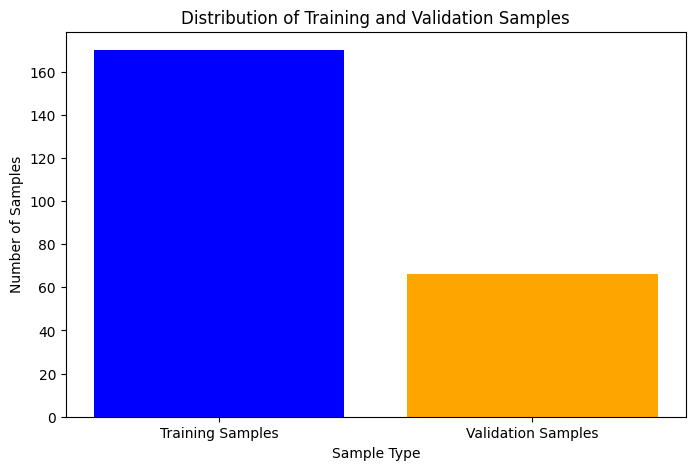

In [6]:
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")



# Visualisasi Data
labels = ['Training Samples', 'Validation Samples']
values = [train_generator.samples, validation_generator.samples]

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'orange'])
plt.title('Distribution of Training and Validation Samples')
plt.xlabel('Sample Type')
plt.ylabel('Number of Samples')
plt.show()

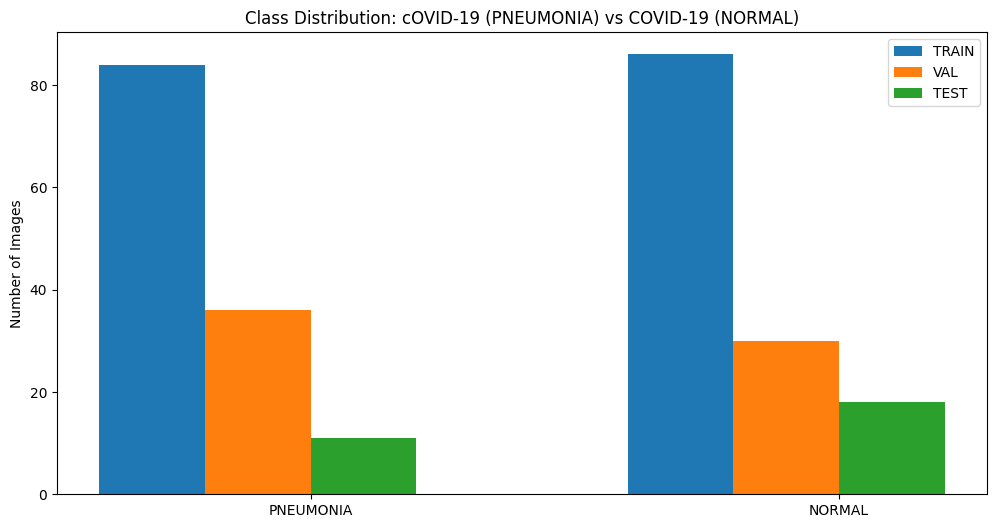

In [7]:
import os
import matplotlib.pyplot as plt

# Fungsi untuk menghitung jumlah file dalam setiap kategori
def count_images(directory):
    categories = ['PNEUMONIA', 'NORMAL']
    counts = {}
    for category in categories:
        path = os.path.join(directory, category)
        counts[category] = len(os.listdir(path))
    return counts

# Hitung distribusi data di TRAIN, VAL, dan TEST
train_counts = count_images(TRAIN_DIR)
val_counts = count_images(VAL_DIR)
test_counts = count_images(TEST_DIR)

# Gabungkan data untuk visualisasi
data = {
    "TRAIN": train_counts,
    "VAL": val_counts,
    "TEST": test_counts
}

# Visualisasi data
labels = ['PNEUMONIA', 'NORMAL']
x = range(len(labels))

plt.figure(figsize=(12, 6))
for i, (dataset, counts) in enumerate(data.items()):
    plt.bar([p + i * 0.2 for p in x], [counts[label] for label in labels], width=0.2, label=dataset)

plt.xticks([p + 0.3 for p in x], labels)
plt.ylabel("Number of Images")
plt.title("Class Distribution: cOVID-19 (PNEUMONIA) vs COVID-19 (NORMAL)")
plt.legend()
plt.show()


Sampel gambar kategori 'PNEUMONIA' (COVID-19):


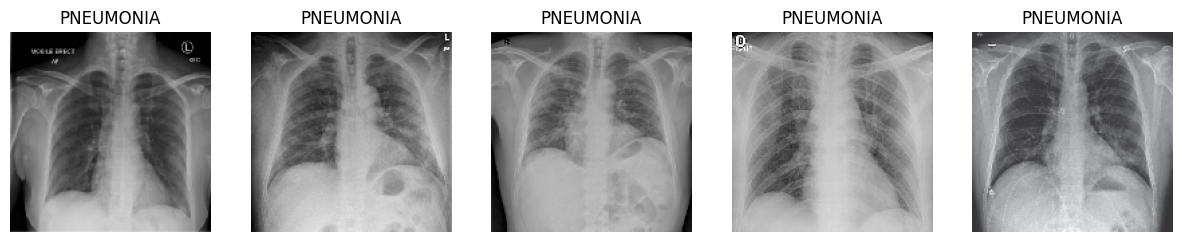

Sampel gambar kategori 'NORMAL' (No PNEUMONIA):


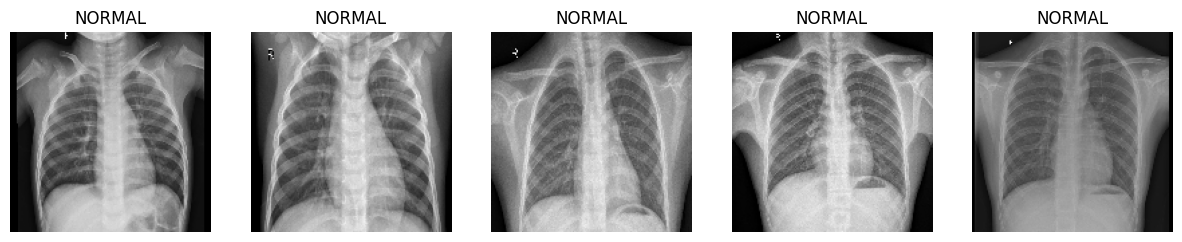

In [8]:
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def visualize_samples(directory, category, num_samples=5):
    """
    Menampilkan beberapa sampel gambar dari kategori tertentu di direktori dataset.
    Args:
        directory (str): Path direktori dataset (TRAIN, VAL, atau TEST).
        category (str): Kategori gambar ('YES' atau 'NO').
        num_samples (int): Jumlah sampel gambar yang ingin ditampilkan.
    """
    path = os.path.join(directory, category)
    images = os.listdir(path)[:num_samples]  # Ambil beberapa gambar
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(path, img_name)
        img = load_img(img_path, target_size=(150, 150))  # Resize ke ukuran yang digunakan dalam model
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
    plt.show()

# Tampilkan sampel gambar dari kategori 'YES' dan 'NO' di TRAIN dataset
print("Sampel gambar kategori 'PNEUMONIA' (COVID-19):")
visualize_samples(TRAIN_DIR, 'PNEUMONIA', num_samples=5)

print("Sampel gambar kategori 'NORMAL' (No PNEUMONIA):")
visualize_samples(TRAIN_DIR, 'NORMAL', num_samples=5)


In [9]:
# Model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Training Model
EPOCHS = 30
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=6)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[es]
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5354 - loss: 0.8072 - val_accuracy: 0.6667 - val_loss: 0.6021
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7254 - loss: 0.6057 - val_accuracy: 0.9848 - val_loss: 0.4352
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8241 - loss: 0.5040 - val_accuracy: 0.9394 - val_loss: 0.3173
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9122 - loss: 0.3077 - val_accuracy: 0.9697 - val_loss: 0.2137
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8730 - loss: 0.2510 - val_accuracy: 0.9848 - val_loss: 0.0979
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9295 - loss: 0.1737 - val_accuracy: 0.9848 - val_loss: 0.0450
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9501 - loss: 0.1030 - val_accuracy: 1.0000 - val_loss: 0.0083
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9779 - loss: 0.0852 - val_accuracy: 0.9697 - val_loss: 0.0870
Epoch 9/30
6/6 ━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


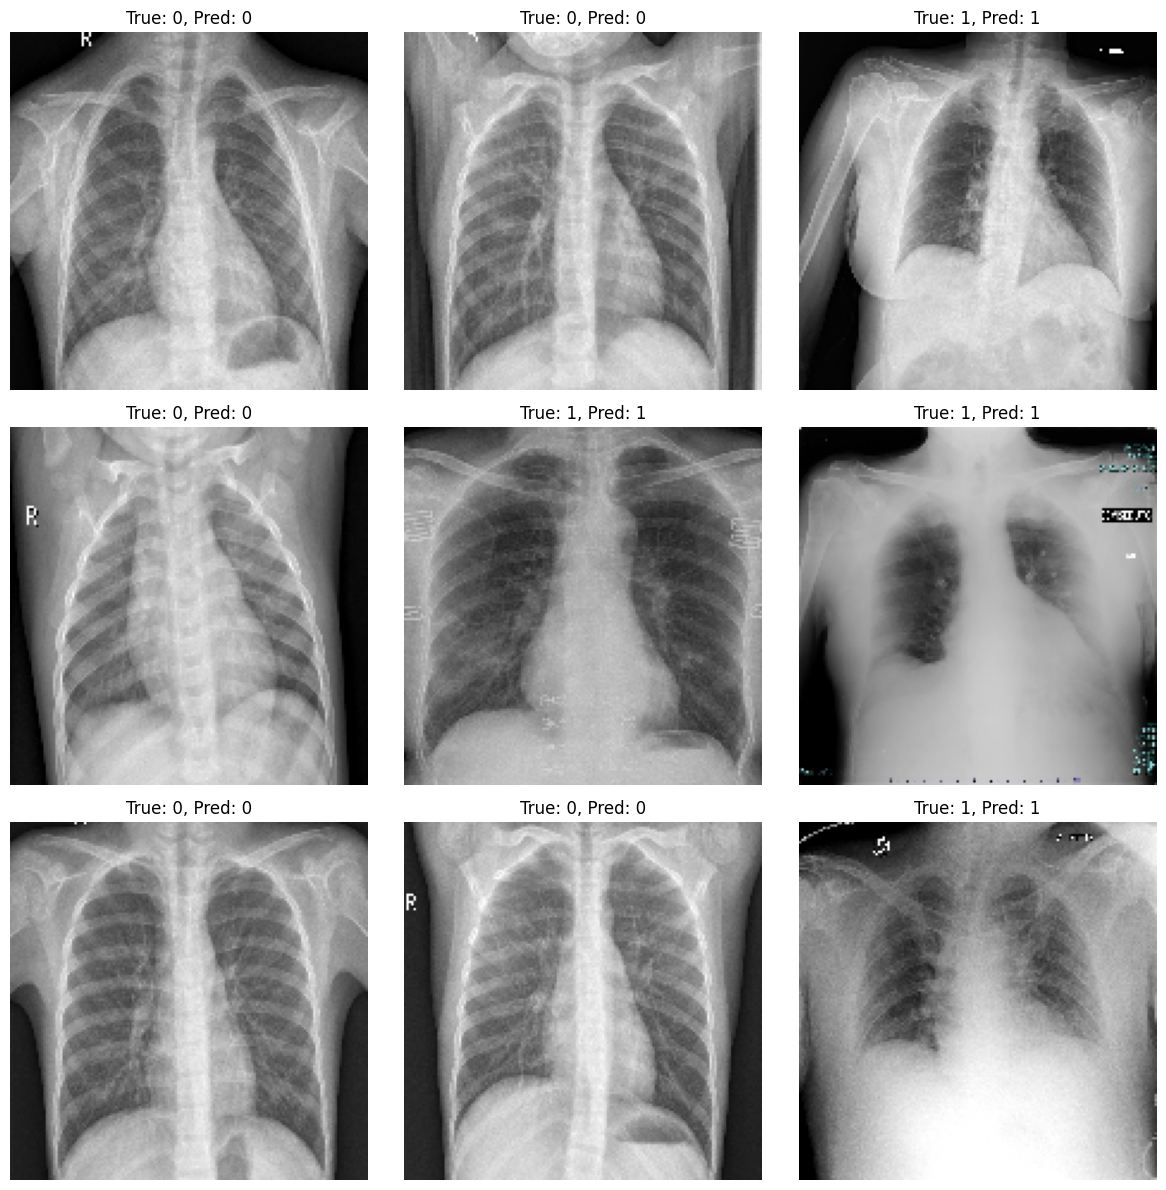

In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt

def plot_predictions(generator, predictions, true_labels, num_images=9):
    # Ambil semua gambar dan label dari generator
    all_data = []
    all_labels = []

    # Reset generator
    generator.reset()

    # Iterasi untuk mengambil semua batch
    for _ in range(len(generator)):
        data, labels = next(generator)
        all_data.append(data)
        all_labels.extend(labels)

    # Gabungkan semua batch menjadi satu array
    all_data = np.concatenate(all_data, axis=0)
    all_labels = np.array(all_labels)

    # Jika gambar dinormalisasi, denormalisasi ke rentang [0, 255]
    if all_data.max() <= 1.0:
        all_data = (all_data * 255).astype("uint8")

    # Ambil subset dari seluruh data untuk plot
    indices = random.sample(range(len(all_data)), min(num_images, len(all_data)))
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    for i, ax in enumerate(axes.flatten()):
        if i >= len(indices):
            break
        idx = indices[i]
        ax.imshow(all_data[idx])  # Gambar dalam uint8 sudah siap ditampilkan
        ax.set_title(f"True: {true_labels[idx]}, Pred: {predictions[idx]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Contoh penggunaan
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

plot_predictions(test_generator, y_pred_classes, test_generator.classes)


Validation Performance:
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step
Accuracy = 0.52


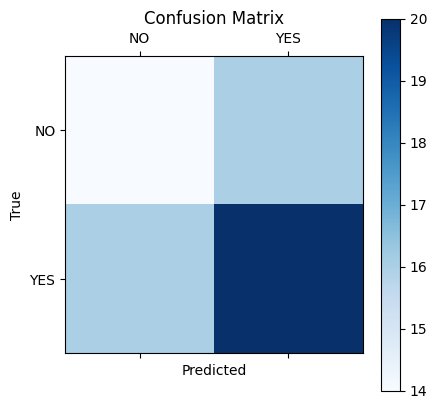

Test Performance:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Accuracy = 1.00


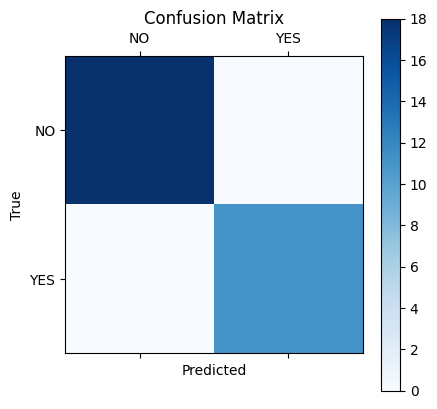

In [12]:

# Evaluasi Model
def evaluate_model(generator, model, labels):
    generator.reset()  # Reset generator untuk memastikan data dimulai dari awal
    predictions = model.predict(generator, steps=len(generator), verbose=1)
    predictions = [1 if x > 0.5 else 0 for x in predictions]

    true_labels = generator.classes  # Mendapatkan label sebenarnya dari generator
    accuracy = accuracy_score(true_labels, predictions)
    print(f'Accuracy = {accuracy:.2f}')

    confusion_mtx = confusion_matrix(true_labels, predictions)
    plt.matshow(confusion_mtx, cmap='Blues')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(ticks=[0, 1], labels=labels)
    plt.yticks(ticks=[0, 1], labels=labels)
    plt.show()
print("Validation Performance:")
evaluate_model(validation_generator, model, labels=['NO', 'YES'])
print("Test Performance:")
evaluate_model(test_generator, model, labels=['NO', 'YES'])

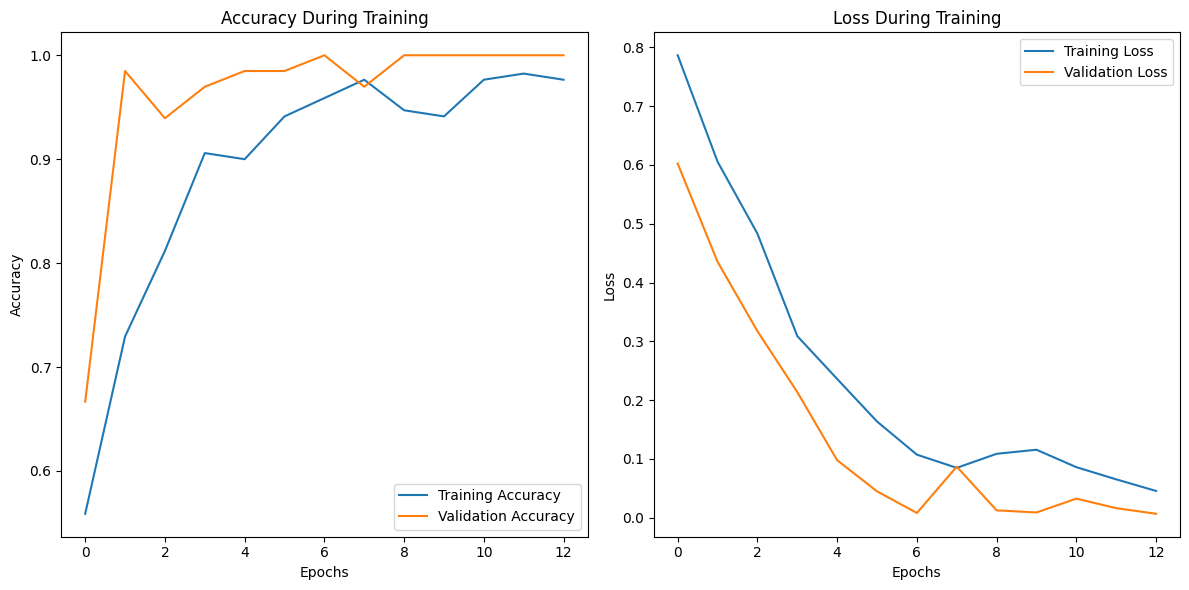

In [13]:
plt.figure(figsize=(12, 6))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
